# CIFAR 10 Residual network

In [0]:
%tensorflow_version 2.0 # Set tf2.0 version in Google Colab
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import StandardScaler
import os
import datetime
import time
import tensorboard
%load_ext tensorboard


(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
#x_train = x_train / 255
#x_test = x_test / 255


y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
print(y_train.shape)
print(y_test.shape)

#x_train = x_train[:500]
#y_train = y_train[:500]


print("Tensorflow version: ",tf.__version__)
print(x_train.shape)


`%tensorflow_version` only switches the major version: `1.x` or `2.x`.
You set: `2.0 # Set tf2.0 version in Google Colab`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.


Using TensorFlow backend.


170500096/170498071 [==============================] - 2s 0us/step
(50000, 10)
(10000, 10)
Tensorflow version:  2.1.0-rc1
(50000, 32, 32, 3)


# Training model with model.fit method

### callbacks

In [0]:
from tensorflow.keras.callbacks import Callback, EarlyStopping, TensorBoard, ModelCheckpoint, LearningRateScheduler
import matplotlib.pyplot as plt
from pylab import rcParams

logdir = 'logs/hparms'
chekpoints_dir = os.path.join('chekpoints', "ckpt_{epoch}")
batch_size = 125 # for having the rest to zero (50000 % 125 = 0)

# plot two separable plots of loss/accuracy model 
def history_model(history):
    plt.subplot(121)
    rcParams['figure.figsize'] = 13, 7
    plt.plot(history['accuracy'])
    plt.plot(history['val_accuracy'])
    plt.title('ResNet accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epochs')
    plt.legend(['train_accuracy', 'val_accuracy'], loc='upper left')

    plt.subplot(122)
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('ResNet loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend(['train_loss', 'val_loss'])

    plt.show()


# defining the callbacks

def lr_schedule(epoch: int):
    lr = 0.1
    if epoch > 180 :
        lr = 0.001
    elif epoch > 90 :
        lr = 0.01
    return lr    
        
tensorboard_callback = TensorBoard(log_dir=logdir, histogram_freq=1, update_freq='epoch', profile_batch = 100000000)  # log metrics
#Keras_callback =   # log hparams
earlyStopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
# Save model after every 3 epochs (150000 / 50000)
checkpoint_callback = ModelCheckpoint(filepath = chekpoints_dir, save_freq='epoch', monitor='val_loss',save_best_only=True, verbose = 1)

class TrainCallback(Callback):

    def __init__(self, x_train, y_train):
        super().__init__()
        self.x_train = x_train
        self.y_train = y_train
    
    def on_epoch_begin(self, epoch, logs=None):
        print("<-----------------------------------------------       EPOCH {}     ----------------------------------------------->".format(epoch+1))
    
    def on_epoch_end(self, epoch, logs=None):
        (loss, acc) = self.model.evaluate(self.x_train, self.y_train, batch_size = 8192, verbose=0, callbacks=[checkpoint_callback])
        print(f"Real Loss on train : {loss}")
        print(f"Real Acc on train : {acc}")
    
    def on_test_begin(self, epoch, logs=None):
        print("\nCalculating the real train loss/accuracy ...")
    

# Let's try different architectures of Resnet

### CNN with convolution_Batch normalization_relu in every block


Train on 50000 samples, validate on 10000 samples
Epoch 1/150
49920/50000 [============================>.] - ETA: 0s - loss: 2.1106 - accuracy: 0.2387
Epoch 00001: val_loss did not improve from 1.68118
50000/50000 [==============================] - 19s 387us/sample - loss: 2.1101 - accuracy: 0.2389 - val_loss: 2.2518 - val_accuracy: 0.2142
Epoch 2/150
49920/50000 [============================>.] - ETA: 0s - loss: 1.7722 - accuracy: 0.3400
Epoch 00002: val_loss did not improve from 1.68118
50000/50000 [==============================] - 19s 376us/sample - loss: 1.7720 - accuracy: 0.3400 - val_loss: 1.8812 - val_accuracy: 0.3412
Epoch 3/150
49920/50000 [============================>.] - ETA: 0s - loss: 1.6262 - accuracy: 0.4001
Epoch 00003: val_loss improved from 1.68118 to 1.59074, saving model to chekpoints/ckpt_3
INFO:tensorflow:Assets written to: chekpoints/ckpt_3/assets
50000/50000 [==============================] - 21s 425us/sample - loss: 1.6263 - accuracy: 0.4001 - val_loss: 1.590

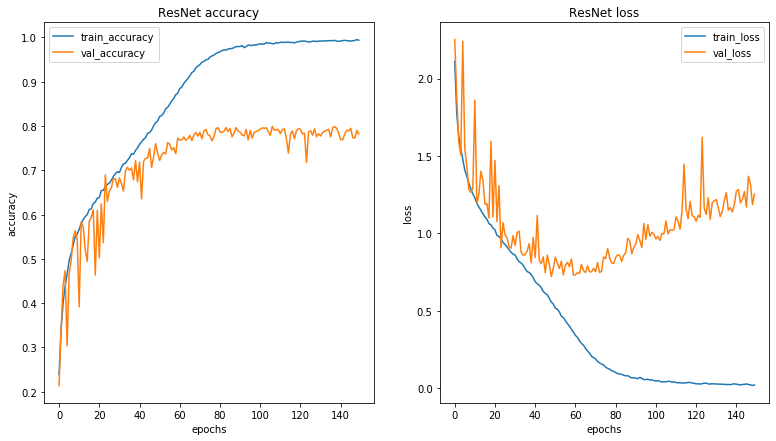

In [0]:
from tensorflow.keras.layers import Input, Add, Conv2D, Dense, Dropout, Flatten, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.layers import MaxPooling2D, BatchNormalization, Activation, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.activations import relu, softmax
from keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, RMSprop

def resnet_model():
    
    input = Input((32, 32,3), name="input")

    conv_1 = Conv2D(64, kernel_size=3,  strides=1, padding='SAME', name="conv_1")(input)
    batch_norm_1 = BatchNormalization(name='batch_norm_1')(conv_1)
    relu_1 = Activation('relu', name='relu_1')(batch_norm_1)

    conv_2 = Conv2D(64, kernel_size=3,  strides=1, padding='SAME', name="conv_2")(relu_1)
    batch_norm_2 = BatchNormalization(name='batch_norm_2')(conv_2)
    relu_2 = Activation('relu', name='relu_2')(batch_norm_2)
    conv_3 = Conv2D(64, kernel_size=3,  strides=1, padding='SAME', name="conv_3")(relu_2)
    batch_norm_3 = BatchNormalization(name='batch_norm_3')(conv_3)

    output_1 = Add(name='add_1')([relu_1, batch_norm_3])
    relu_3 = Activation('relu', name='relu_3')(output_1)

    conv_4 = Conv2D(64, kernel_size=3,  strides=1, padding='SAME', name="conv_4")(relu_3)
    batch_norm_4 = BatchNormalization(name='batch_norm_4')(conv_4)
    relu_4 = Activation('relu', name='relu_4')(batch_norm_4)
    conv_5 = Conv2D(64, kernel_size=3,  strides=1, padding='SAME', name="conv_5")(relu_4)
    batch_norm_5 = BatchNormalization(name='batch_norm_5')(conv_5)

    output_2 = Add(name='add_2')([relu_3, batch_norm_5])
    relu_5 = Activation('relu', name='relu_5')(output_2)

    pooling = AveragePooling2D(name='AveragePooling2D')(relu_5)

    flatten = Flatten(name="flatten")(pooling)
    fc_1 = Dense(128, activation='sigmoid', name='fully_connected')(flatten)
    dropout = Dropout(0.3, name='dropout')(fc_1)    
    output = Dense(10, activation='softmax', name='output')(dropout)
    model = Model(input, output)
    
    return model
    
model = resnet_model()
plot_model(model, 'resnet.png')

model.compile(
  optimizer=Adam(learning_rate=0.001),
  loss='categorical_crossentropy',
  metrics=['accuracy'],
)

hist = model.fit(x_train, y_train , epochs=150,
                 batch_size=256,
                 validation_data=(x_test, y_test),
                 callbacks=[checkpoint_callback])

history_model(hist.history)

### CNN with 5 blocks of convolution

In [0]:
from tensorflow.keras.layers import Input, Add, Conv2D, Dense, Dropout, Flatten, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.layers import MaxPooling2D, BatchNormalization, Activation, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.activations import relu, softmax
from keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, RMSprop

def resnet_model():
    
    input = Input((32, 32,3), name="input")

    conv_0 = Conv2D(64, kernel_size=3, activation='relu', strides=1, padding='SAME', name="conv_0")(input)
    pool_0 = MaxPooling2D(pool_size=(2, 2), name='pool_0')(conv_0)

    conv_1 = Conv2D(64, kernel_size=3, activation='relu', strides=1, padding='SAME', name="conv_1")(pool_0)
    conv_2 = Conv2D(64, kernel_size=3, activation='relu', strides=1, padding='SAME', name="conv_2")(conv_1)
    output_1 = Add(name='add_1')([pool_0, conv_2])

    conv_3 = Conv2D(64, kernel_size=3, activation='relu', strides=1, padding='SAME', name="conv_3")(output_1)
    conv_4 = Conv2D(64, kernel_size=3, activation='relu', strides=1, padding='SAME', name="conv_4")(conv_3)
    output_2 = Add(name='add_2')([output_1, conv_4])

    conv_5 = Conv2D(64, kernel_size=3, activation='relu', strides=1, padding='SAME', name="conv_5")(output_2)
    conv_6 = Conv2D(64, kernel_size=3, activation='relu', strides=1, padding='SAME', name="conv_6")(conv_5)
    output_3 = Add(name='add_3')([output_2, conv_6])

    conv_7 = Conv2D(64, kernel_size=3, activation='relu', strides=1, padding='SAME', name="conv_7")(output_3)
    conv_8 = Conv2D(64, kernel_size=3, activation='relu', strides=1, padding='SAME', name="conv_8")(conv_7)
    output_4 = Add(name='add_4')([output_3, conv_8])
    
    conv_9 = Conv2D(64, kernel_size=3, activation='relu', strides=1, padding='SAME', name="conv_9")(output_4)
    conv_10 = Conv2D(64, kernel_size=3, activation='relu', strides=1, padding='SAME', name="conv_10")(conv_9)
    output_5 = Add(name='add_5')([output_4, conv_10])

    pooling = GlobalAveragePooling2D(name='globalAveragePooling2D')(output_5)

    flatten = Flatten(name="flatten")(pooling)
    fc_1 = Dense(128, activation='relu', name='fully_connected')(flatten)
    dropout = Dropout(0.2, name='dropout')(fc_1)    
    output = Dense(10, activation='softmax', name='output')(dropout)
    model = Model(input, output)
    
    return model
    
model = resnet_model()
plot_model(model, 'resnet_with_5_blocks.png')

model.compile(
  optimizer=Adam(learning_rate=0.001),
  loss='categorical_crossentropy',
  metrics=['accuracy'],
)

hist = model.fit(x_train, y_train , epochs=100,
                 batch_size=256,
                 validation_data=(x_test, y_test),
                 callbacks=[checkpoint_callback])

history_model(hist.history)

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
49920/50000 [============================>.] - ETA: 0s - loss: 3.6453 - accuracy: 0.2544
Epoch 00001: val_loss did not improve from 0.66637
50000/50000 [==============================] - 22s 430us/sample - loss: 3.6425 - accuracy: 0.2545 - val_loss: 1.6767 - val_accuracy: 0.3737
Epoch 2/100
49920/50000 [============================>.] - ETA: 0s - loss: 1.5694 - accuracy: 0.4227
Epoch 00002: val_loss did not improve from 0.66637
50000/50000 [==============================] - 20s 405us/sample - loss: 1.5692 - accuracy: 0.4228 - val_loss: 1.5046 - val_accuracy: 0.4710
Epoch 3/100
49920/50000 [============================>.] - ETA: 0s - loss: 1.4052 - accuracy: 0.4914
Epoch 00003: val_loss did not improve from 0.66637
50000/50000 [==============================] - 20s 409us/sample - loss: 1.4056 - accuracy: 0.4915 - val_loss: 1.3108 - val_accuracy: 0.5196
Epoch 4/100
49920/50000 [============================>.] - ETA: 0s - loss:

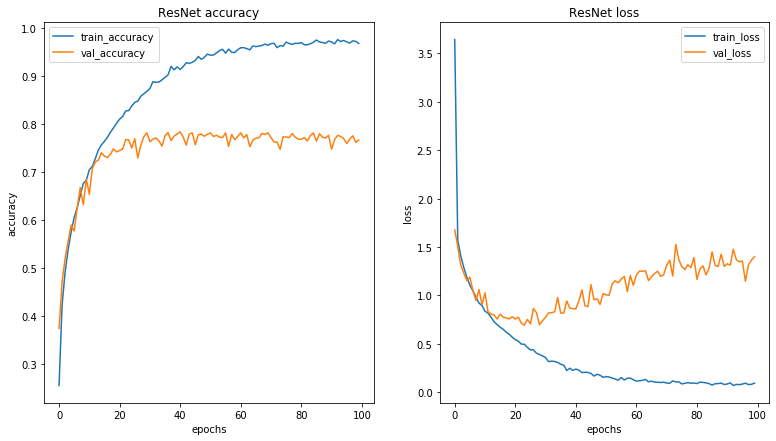

In [0]:
history_model(hist.history)

### CNN with 3 blocks of convolution

Train on 50000 samples, validate on 10000 samples
Epoch 1/150
49920/50000 [============================>.] - ETA: 0s - loss: 3.6206 - accuracy: 0.2424
Epoch 00001: val_loss improved from inf to 1.70009, saving model to chekpoints/ckpt_1
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: chekpoints/ckpt_1/assets
50000/50000 [==============================] - 22s 447us/sample - loss: 3.6176 - accuracy: 0.2425 - val_loss: 1.7001 - val_accuracy: 0.3624
Epoch 2/150
49920/50000 [============================>.] - ETA: 0s - loss: 1.6416 - accuracy: 0.3950
Epoch 00002: val_loss improved from 1.70009 to 1.52464, saving model to chekpoints/ckpt_2
INFO:tensorflow:Assets written to: chekpoints/ckpt_2/assets
50000/50000 [==============================] - 15s 302us/sample - loss: 1.6413 - accuracy: 0.3951 - val_loss: 1.5246 - val_accuracy: 0.4309
Epoch 3/150
49920/50000 [============================>.] - ETA: 0s - loss: 1.4672 - accurac

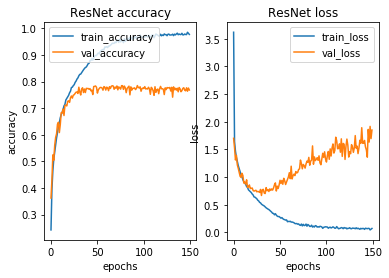

In [0]:
from tensorflow.keras.layers import Input, Add, Conv2D, Dense, Dropout, Flatten, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.layers import MaxPooling2D, BatchNormalization, Activation, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.activations import relu, softmax
from keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, RMSprop

def resnet_model():
    
    input = Input((32, 32,3), name="input")

    conv_0 = Conv2D(64, kernel_size=3, activation='relu', strides=1, padding='SAME', name="conv_0")(input)
    pool_0 = MaxPooling2D(pool_size=(2, 2), name='pool_0')(conv_0)

    conv_1 = Conv2D(64, kernel_size=3, activation='relu', strides=1, padding='SAME', name="conv_1")(pool_0)
    conv_2 = Conv2D(64, kernel_size=3, activation='relu', strides=1, padding='SAME', name="conv_2")(conv_1)
    output_1 = Add(name='add_1')([pool_0, conv_2])

    conv_3 = Conv2D(64, kernel_size=3, activation='relu', strides=1, padding='SAME', name="conv_3")(output_1)
    conv_4 = Conv2D(64, kernel_size=3, activation='relu', strides=1, padding='SAME', name="conv_4")(conv_3)
    output_2 = Add(name='add_2')([output_1, conv_4])

    conv_5 = Conv2D(64, kernel_size=3, activation='relu', strides=1, padding='SAME', name="conv_5")(output_2)
    conv_6 = Conv2D(64, kernel_size=3, activation='relu', strides=1, padding='SAME', name="conv_6")(conv_5)
    output_3 = Add(name='add_3')([output_2, conv_6])
    

    pooling = GlobalAveragePooling2D(name='globalAveragePooling2D')(output_3)

    flatten = Flatten(name="flatten")(pooling)
    fc_1 = Dense(128, activation='relu', name='fully_connected')(flatten)
    dropout = Dropout(0.2, name='dropout')(fc_1)    
    output = Dense(10, activation='softmax', name='output')(dropout)
    model = Model(input, output)
    
    return model
    
model = resnet_model()
plot_model(model, 'resnet2.png')

model.compile(
  optimizer=Adam(learning_rate=0.001),
  loss='categorical_crossentropy',
  metrics=['accuracy'],
)

hist = model.fit(x_train, y_train , epochs=150,
                 batch_size=256,
                 validation_data=(x_test, y_test),
                 callbacks=[checkpoint_callback])

history_model(hist.history)

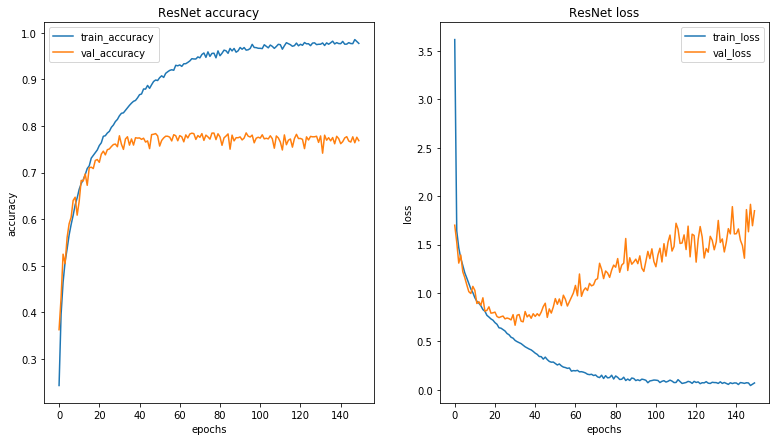

In [0]:
history_model(hist.history) 

# let's run some tests

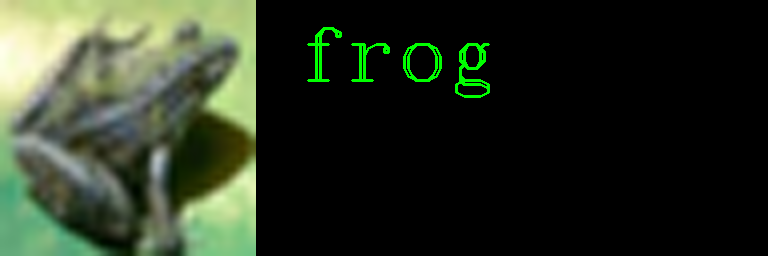

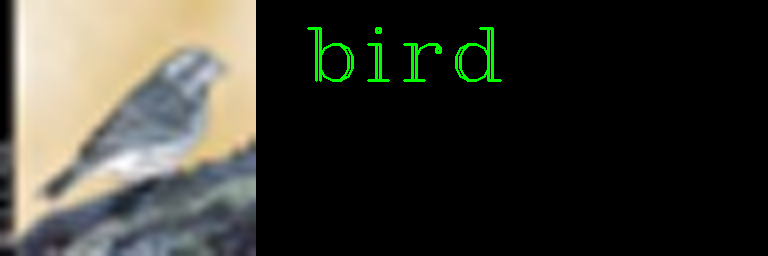

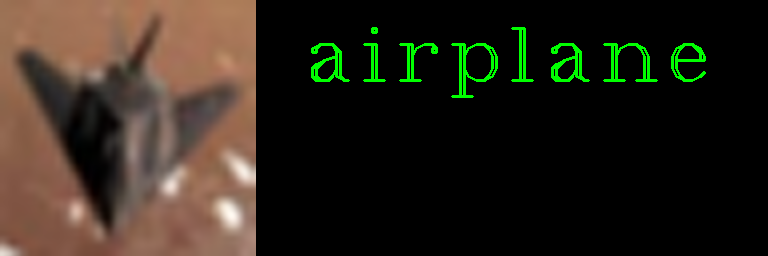

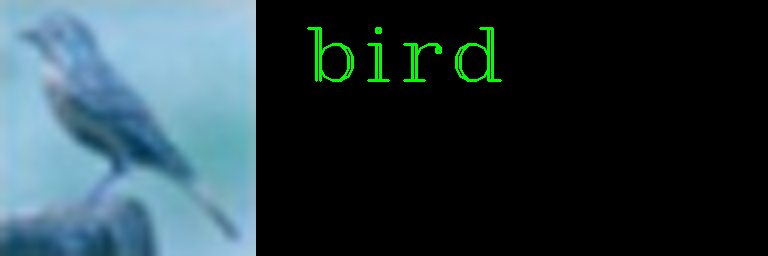

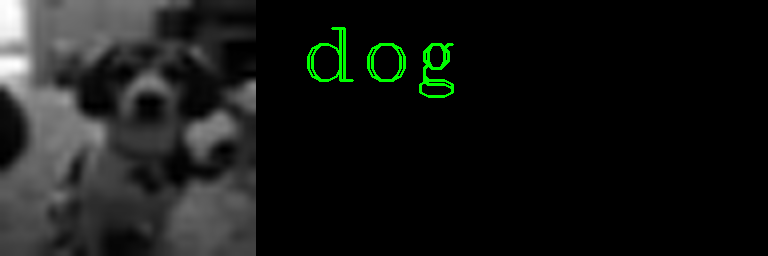

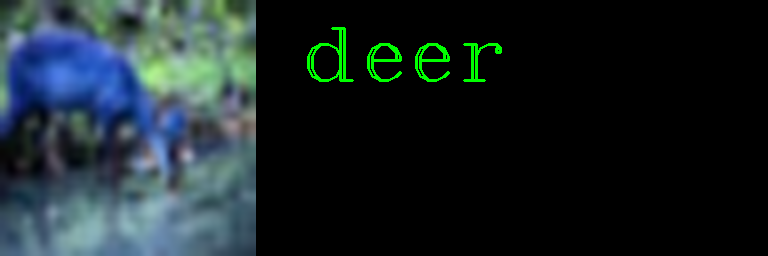

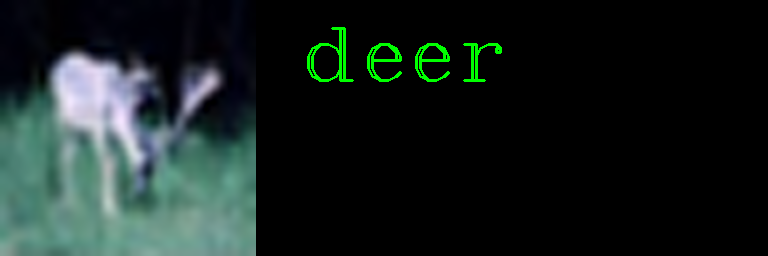

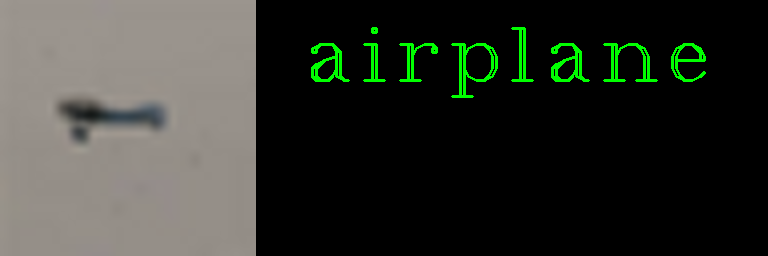

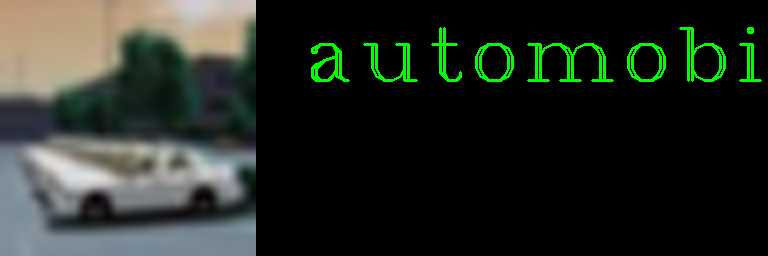

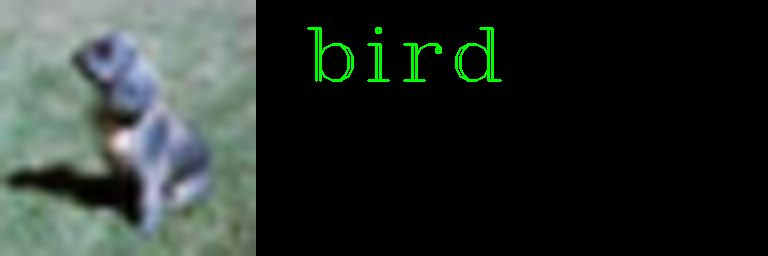

In [65]:
import cv2
import numpy as np
from keras.models import load_model
from google.colab.patches import cv2_imshow

img_row, img_height, img_depth = 32,32,3
color = True
scale = 8

#model = model.load_weights(tf.train.latest_checkpoint('/content/chekpoints'))
#eval_loss, eval_acc = model.evaluate(x_test, y_test)
#print('Eval loss: {}, Eval Accuracy: {}'.format(eval_loss, eval_acc))

def draw_test(name, res, input_im, scale, img_row, img_height):
    BLACK = [0,0,0]
    res = int(res)
    if res == 0:
        pred = "airplane"
    if res == 1:
        pred = "automobile"
    if res == 2:
        pred = "bird"
    if res == 3:
        pred = "cat"
    if res == 4:
        pred = "deer"
    if res == 5:
        pred = "dog"
    if res == 6:
        pred = "frog"
    if res == 7:
        pred = "horse"
    if res == 8:
        pred = "ship"
    if res == 9:
        pred = "truck"
        
    expanded_image = cv2.copyMakeBorder(input_im, 0, 0, 0, imageL.shape[0]*2 ,cv2.BORDER_CONSTANT,value=BLACK)
    if color == False:
        expanded_image = cv2.cvtColor(expanded_image, cv2.COLOR_GRAY2BGR)
    cv2.putText(expanded_image, str(pred), (300, 80) , cv2.FONT_HERSHEY_COMPLEX_SMALL,4, (0,255,0), 2)
    cv2_imshow( expanded_image)
    #cv2.imshow(name, expanded_image)


for i in range(0,10):
    rand = np.random.randint(0,len(x_test))
    input_im = x_test[rand]
    imageL = cv2.resize(input_im, None, fx=scale, fy=scale, interpolation = cv2.INTER_CUBIC) 
    input_im = input_im.reshape(1,img_row, img_height, img_depth) 
    
    ## Get Prediction
    res = model.predict(input_im)
    res = np.where(res[0] == max(res[0]))[0][0]
    draw_test("Prediction", res, imageL, scale, img_row, img_height) 
    cv2.waitKey(0)

cv2.destroyAllWindows()